In [2]:
import pandas as pd 
import numpy as np 
from dataImporter import get_IC_data
from dataProcesser import interpolate_flux, get_flux
import matplotlib.pyplot as plt
interp_flux = interpolate_flux()
 
#IC_MC = np.load('./pre_computed/IC_MC.npy')
from dataImporter import get_IC_data
ic_res_full = get_IC_data().T
livetime_norm = 240747841/(343.7*24*3600)
IC_obs =ic_res_full 
zreco = np.linspace(-1.0,0,21)
Ereco = 500*10**np.linspace(0.0,1.3,14)

In [2]:
filename = '~/NuFSGenMC_nominal.dat'
df = pd.read_csv(filename, delimiter=' ', names= ['pdg', 'Ereco', 'zreco', 'Etrue', 'ztrue', 'mcweight', 'flux_pion', 'flux_kaon'], skiprows=12)
num_mask = (df["pdg"] == 13)
nuam_mask = (df["pdg"] == -13)

In [3]:
# Use my flux 
df.loc[num_mask,'flux'] = get_flux('m',df[num_mask].Etrue,df[num_mask].ztrue,interp_flux) #df[num_mask].flux_pion + df[num_mask].flux_kaon 
df.loc[nuam_mask, 'flux'] = get_flux('mbar',df[nuam_mask].Etrue,df[nuam_mask].ztrue,interp_flux) #df[nuam_mask].flux_pion + df[nuam_mask].flux_kaon
df = df.dropna() #We get NaNs where the flux cant be found, for positive ztrue. We can just drop these
df['weight'] = (livetime_norm* df.mcweight*df.flux/1e4) #Adjust livetime to 8 years #weights are given in cm^2. our flux is in 1/m^2

In [3]:
#Use provided flux
df['weight'] = livetime_norm*df.mcweight*(df.flux_pion + df.flux_kaon)

In [5]:
df_binned = df.copy()
df_binned['Ebin'] = pd.cut(df_binned.Ereco, bins=Ereco)
df_binned['zbin'] = pd.cut(df_binned.zreco, bins=zreco)

df_grouped = df_binned.groupby(by=['Ebin', 'zbin']).sum()[['weight']].dropna()
IC_MC = np.array(df_grouped).reshape(13,20)
np.save('./pre_computed/IC_MC.npy',IC_MC)

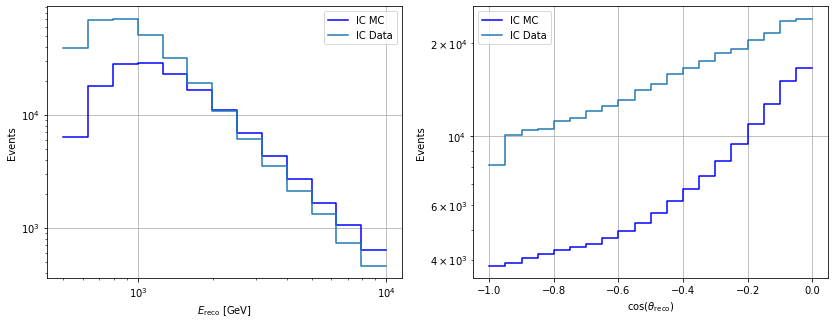

In [4]:
MC_original_bins = np.logspace(np.log10(4e2), np.log10(2e4), num=28) #From the paper. Dont use unless you want to reproduce fig 2 

E_events, _= np.histogram(df.Ereco, weights=df.weight, bins=Ereco )
IC_obs_E = np.sum(IC_obs, axis=1)

z_events, _= np.histogram(df.zreco, weights=df.weight, bins=zreco )
IC_obs_z = np.sum(IC_obs, axis=0)


# Plot
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].step(Ereco, np.append(E_events,E_events[-1]), where="post", color="blue", label='IC MC' )
ax[0].step(Ereco, np.append(IC_obs_E.values,IC_obs_E.values[-1]), where='post', label='IC Data')
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel(r"$E_{\rm{reco}}$ [GeV]")
ax[0].set_ylabel(r"Events")
ax[0].grid(True)
_ = ax[0].legend()

ax[1].step(zreco, np.append(z_events,z_events[-1]), where="post", color="blue", label='IC MC' )
ax[1].step(zreco, np.append(IC_obs_z.values,IC_obs_z.values[-1]), where='post', label='IC Data')
ax[1].set_yscale("log")
ax[1].set_xlabel(r"$\cos{(\theta_{\rm{reco}}})$")
ax[1].set_ylabel(r"Events")
ax[1].grid(True)
_ = ax[1].legend()

In [94]:
from dataImporter import get_Aeff_df_2012
from dataProcesser import interpolate_Aeff_2012
aeff_df = get_Aeff_df_2012()
interp_aeff = interpolate_Aeff_2012(aeff_df)

In [246]:
z = np.linspace(-1,0,5)
te = pd.DataFrame()
t= df[num_mask]#.sample(10000)
for i in range(len(z)-1):
    left_z = z[i]
    right_z = z[i+1]
    sub_df = t[(t.ztrue < right_z) & (t.ztrue>left_z)]
    aeff, bin_edges_num = np.histogram(sub_df.Etrue, weights=sub_df.mcweight, bins=energy_bins_fine )
    aeff /= 2. * np.pi # Normalise by steradian
    aeff /= np.diff(bin_edges_num) # Bin widths
    aeff = aeff/1e4/(343.7*24*3600) # units to m^2 and livetime in seconds
    te.insert(i,left_z,aeff)
te.index = bin_edges_num[0:20]

,199.526231,305.492111,467.735141,716.143410,1096.478196,1678.804018,2570.395783,3935.500755,6025.595861,9225.714272,14125.375446,21627.185237,33113.112148,50699.070827,77624.711663,118850.222744,181970.085861,278612.116863,426579.518802,653130.552647
-1.00,0.000105,0.001253,0.005868,0.018656,0.050429,0.122242,0.275822,0.574557,1.155880,2.168793,3.890301,6.585486,10.788388,16.442628,24.487205,35.106470,36.955044,48.727709,62.499402,68.543494
-0.75,0.000069,0.000957,0.004922,0.016315,0.044941,0.112385,0.257331,0.551625,1.088426,2.099205,3.854480,6.404024,10.375173,15.610805,21.771015,28.920142,39.664762,50.195936,48.125310,44.951623
-0.50,0.000126,0.001111,0.004824,0.015857,0.044246,0.110479,0.256467,0.553313,1.135560,2.174916,3.949628,7.030433,11.139740,17.524382,24.432333,33.345031,35.154602,54.456761,43.407519,54.346064
-0.25,0.000174,0.001349,0.005510,0.017335,0.047712,0.114758,0.274342,0.590094,1.179256,2.305017,4.090159,7.485518,12.196836,18.708804,25.162358,34.077716,41.450719,50.799532,74.103144,75.996977


<Figure size 432x288 with 0 Axes>

In [43]:
df = pickle.load(open("./pre_computed/aeff.p", "rb"))[0]

,-1.00,-0.99,-0.98,-0.97,-0.96,-0.95,-0.94,-0.93,-0.92,-0.91,...,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0.00
199.053585,0.000007,0.000003,0.000002,0.000001,0.000002,0.000001,0.000001,0.000001,9.661536e-07,9.611412e-07,...,0.000002,0.000004,0.000004,0.000003,0.000003,0.000003,0.000002,0.000003,0.000002,0.000001
250.593617,0.000023,0.000015,0.000013,0.000011,0.000009,0.000008,0.000008,0.000009,8.278717e-06,8.176971e-06,...,0.000014,0.000013,0.000013,0.000014,0.000015,0.000012,0.000012,0.000011,0.000010,0.000007
315.478672,0.000053,0.000047,0.000042,0.000038,0.000037,0.000038,0.000032,0.000029,3.082037e-05,3.206110e-05,...,0.000039,0.000037,0.000035,0.000042,0.000039,0.000038,0.000039,0.000038,0.000034,0.000026
397.164117,0.000110,0.000117,0.000101,0.000091,0.000103,0.000092,0.000092,0.000084,9.293458e-05,8.932682e-05,...,0.000091,0.000091,0.000098,0.000096,0.000093,0.000093,0.000091,0.000096,0.000079,0.000065
500.000000,0.000220,0.000223,0.000220,0.000230,0.000214,0.000200,0.000209,0.000201,1.971931e-04,2.017136e-04,...,0.000187,0.000193,0.000191,0.000201,0.000193,0.000200,0.000187,0.000197,0.000176,0.000136
629.462706,0.000408,0.000419,0.000434,0.000433,0.000408,0.000408,0.000428,0.000394,3.895928e-04,3.804581e-04,...,0.000358,0.000376,0.000375,0.000422,0.000376,0.000387,0.000390,0.000370,0.000334,0.000285
792.446596,0.000710,0.000734,0.000805,0.000757,0.000784,0.000720,0.000739,0.000721,7.157901e-04,7.033115e-04,...,0.000702,0.000707,0.000688,0.000740,0.000717,0.000711,0.000700,0.000661,0.000640,0.000491
997.631157,0.001103,0.001232,0.001364,0.001310,0.001306,0.001287,0.001278,0.001274,1.295126e-03,1.297091e-03,...,0.001156,0.001196,0.001170,0.001323,0.001177,0.001171,0.001188,0.001146,0.001063,0.000919
1255.943216,0.001951,0.002180,0.002110,0.002163,0.002398,0.002205,0.002106,0.002083,2.179984e-03,2.236045e-03,...,0.002019,0.002007,0.001928,0.002057,0.002071,0.002123,0.002199,0.002085,0.001882,0.001592
1581.138830,0.002986,0.003266,0.003718,0.003847,0.003720,0.003686,0.003616,0.003535,3.527808e-03,3.559143e-03,...,0.003362,0.003288,0.003195,0.003445,0.003466,0.003385,0.003433,0.003835,0.003266,0.002559


In [112]:
filename = '~/NuFSGenMC_nominal.dat'
mc_df = pd.read_csv(filename, delimiter=' ', names= ['pdg', 'Ereco', 'zreco', 'Etrue', 'ztrue', 'mcweight', 'flux_pion', 'flux_kaon'], skiprows=12)
#df.mcweight = df.mcweight/1e4 #weights are given in cm^2. our flux is in 1/m^2
num_mask = (mc_df["pdg"] == 13)
nuam_mask = (mc_df["pdg"] == -13)
energy_bins_fine = 500*10**np.linspace(-0.4,2.2,27)
z = np.linspace(-1,0.01,102)

df_list=[]
t= mc_df.sample(1000)
for flavor_df in [t[num_mask], t[nuam_mask]]:
    df = pd.DataFrame(columns=['Etrue','ztrue','aeff'])
    for i in range(len(z)-1):
        left_z = z[i]
        right_z = z[i+1]
        sub_df = flavor_df[(flavor_df.ztrue < right_z) & (flavor_df.ztrue>left_z)]
        aeff, bin_edges_num = np.histogram(sub_df.Etrue, weights=sub_df.mcweight, bins=energy_bins_fine )
        n_items = len(aeff)
        aeff /= 2. * np.pi # Normalise by steradian
        aeff /= np.diff(bin_edges_num) # Bin widths
        aeff = aeff/1e4/(343.7*24*3600) # units to m^2 and livetime in seconds
        new_rows = np.array([bin_edges_num[0:n_items],[left_z]*n_items,aeff])
        new_df = pd.DataFrame(new_rows.T, columns=['Etrue','ztrue','aeff'])
        df= pd.concat([df,new_df], ignore_index=True)
    df_list.append(df)
#print(df_list)

[             Etrue  ztrue          aeff
0       199.053585   -1.0  0.000000e+00
1       250.593617   -1.0  0.000000e+00
2       315.478672   -1.0  0.000000e+00
3       397.164117   -1.0  1.504567e-08
4       500.000000   -1.0  0.000000e+00
...            ...    ...           ...
2621  25059.361681    0.0  0.000000e+00
2622  31547.867224    0.0  0.000000e+00
2623  39716.411736    0.0  0.000000e+00
2624  50000.000000    0.0  0.000000e+00
2625  62946.270590    0.0  0.000000e+00

[2626 rows x 3 columns],              Etrue  ztrue          aeff
0       199.053585   -1.0  0.000000e+00
1       250.593617   -1.0  0.000000e+00
2       315.478672   -1.0  0.000000e+00
3       397.164117   -1.0  8.538091e-09
4       500.000000   -1.0  3.566016e-08
...            ...    ...           ...
2621  25059.361681    0.0  0.000000e+00
2622  31547.867224    0.0  0.000000e+00
2623  39716.411736    0.0  0.000000e+00
2624  50000.000000    0.0  0.000000e+00
2625  62946.270590    0.0  0.000000e+00

[2626 rows x

In [113]:
df = pickle.load(open("./pre_computed/aeff.p", "rb"))[0]

In [78]:
pd.DataFrame(columns=['Etrue','ztrue','aeff'])

,Etrue,ztrue,aeff


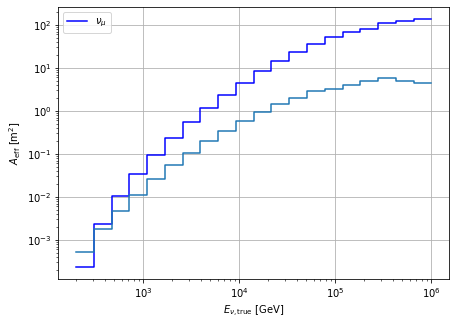

In [135]:
energy_bins_fine = np.logspace(2.3, 6, num=21)
# Calc effective area
t= df[num_mask]#.sample(10000)
Etrue = t.Etrue
mcweight = t.mcweight
num_aeff, bin_edges_num = np.histogram(Etrue, weights=mcweight, bins=energy_bins_fine )
num_aeff /= 4. * np.pi # Normalise by solid angle (using the fully sky)
num_aeff /= np.diff(bin_edges_num) # Bin widths


interpolated_aeff = interp_aeff(energy_bins_fine,-0.85) / (4*np.pi)

# Plot
fig, ax = plt.subplots(figsize=(7,5))
ax.step( bin_edges_num, np.append(num_aeff,num_aeff[-1])/1e4/(343.7*24*3600), where="post", color="blue", label=r"$\nu_\mu$" )
ax.step(energy_bins_fine, interpolated_aeff, where='post')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")
ax.set_ylabel(r"$A_{\rm{eff}}$ [$\rm{m^2}$]")
ax.grid(True)
_ = ax.legend()

In [55]:
filename = '~/NuFSGenMC_nominal.dat'
df = pd.read_csv(filename, delimiter=' ', names= ['pdg', 'Ereco', 'zreco', 'Etrue', 'ztrue', 'mcweight', 'flux_pion', 'flux_kaon'], skiprows=12)
df['Ebin'] = pd.cut(df.Ereco, bins=500*10**np.linspace(0.0,1.3,14), labels=False).dropna()
df

,pdg,Ereco,zreco,Etrue,ztrue,mcweight,flux_pion,flux_kaon,Ebin
0,-13,689.2225,-0.979026,494.8771,-0.979215,1.717731e+07,4.539741e-11,4.621899e-11,1.0
1,13,2705.2740,-0.194269,12439.6900,-0.186481,1.245700e+11,1.636852e-15,6.698746e-15,7.0
2,-13,2969.8830,-0.327984,2986.8660,-0.357066,2.406686e+09,1.543665e-13,2.908331e-13,7.0
3,13,1395.9700,-0.619641,4622.8970,-0.621212,1.243563e+10,2.026703e-14,8.488414e-14,4.0
4,13,2238.9330,-0.805304,5967.7290,-0.806822,2.643217e+10,5.841866e-15,2.645876e-14,6.0
...,...,...,...,...,...,...,...,...,...
8784612,13,1098.5200,-0.845367,1906.8060,-0.841548,6.114175e+08,3.920014e-13,1.431658e-12,3.0
8784613,13,1279.2490,-0.021712,1715.3310,-0.020740,2.745023e+09,3.802741e-12,4.867093e-12,4.0
8784614,-13,1572.5630,-0.306840,724.5060,-0.298991,7.348430e+06,2.828133e-11,2.395735e-11,4.0
8784615,-13,773.8640,-0.057704,385.4801,-0.062174,2.091010e+06,3.040176e-10,3.093614e-10,1.0


In [4]:
df_bin0 = df[df.Ebin==0.].sample(2000, random_state=0)
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
X = np.array(np.log(df_bin0.Ereco)).reshape(-1,1)
y = np.log(df_bin0.Etrue)

In [5]:
kernel2  = 1.0 * RBF() + WhiteKernel(noise_level=3)
gpr = GaussianProcessRegressor(kernel=kernel2,random_state=0).fit(X, y)

In [62]:
df1 = df
df1.Ereco = np.round(df1.Ereco,2)
df1 = df1.groupby('Ereco').mean().reset_index()

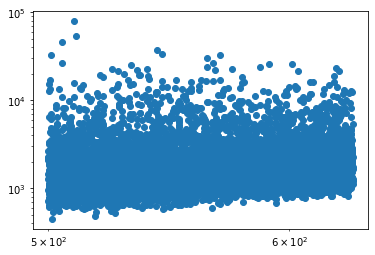

In [64]:
plt.scatter(df1[df1.Ebin==0.].Ereco, df1[df1.Ebin==0.].Etrue)
plt.xscale('log')
plt.yscale('log')

In [92]:
from dataProcesser import train_energy_resolution
model = train_energy_resolution()
model.predict(np.log(500).reshape(-1,1))

array([6.56910205])

(50, 1) (50,)


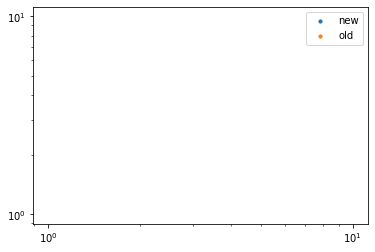

In [72]:
x_test = np.logspace(np.log10(500*10**0.0),np.log10(500*10**0.1)).reshape(-1,1)
new,_,_ = get_Etrue(gpr, 50, 99, 99,Ereco=x_test)
old,_,_ = get_Etrue(model, 50, 99, 99,Ereco=x_test)
#plt.scatter(np.exp(X),np.exp(y), s=2, label='data')
plt.scatter(x_test, new, s=10, label='new')
#plt.scatter(x_test, np.exp(gpr.sample_y(np.log(x_test))), s=10, label='new')
plt.scatter(x_test, old, s=10, label='old')
#plt.scatter(x_test, np.exp(model.sample_y(np.log(x_test))), s=10, label='old')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [65]:
from scipy.stats import lognorm
def get_Etrue(model, npoints, left_alpha, right_alpha,E_index=None,Ereco=False):
    E_buckets = 500*10**(np.linspace(0.0,1.3,14))
    if not E_index is None:
        Ereco = np.logspace(np.log10(E_buckets[E_index]), np.log10(E_buckets[E_index+1]), npoints)
    mu_base_e, std_base_e = model.predict(np.log(Ereco).reshape(-1,1), return_std=True)
    Etrue = np.logspace(np.log10(lognorm.ppf(1-left_alpha, s=std_base_e[0], scale= np.exp(mu_base_e[0]))), 
                         np.log10(lognorm.ppf(right_alpha, s=std_base_e[-1], scale= np.exp(mu_base_e[-1]))),npoints)
    return Etrue, mu_base_e, std_base_e